[https://github.com/noahbenson/neuropythy/wiki/Retinotopy](
https://github.com/noahbenson/neuropythy/wiki/Retinotopy)

In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import scipy
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import subprocess
import warnings

In [3]:
import nibabel as nb
from nilearn import plotting, image
from nilearn.maskers import NiftiLabelsMasker
from nipype.interfaces import fsl

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [9]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)

In [10]:
list_sn = su.get_list_sn()

---

In [11]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [12]:
list_roi = simage.get_list_roi()

In [13]:
border, brdr = simage.get_border(join(dir_git,'surfAnalysisPy'))
hem = 'L'

In [14]:
dir_group = join(dir_surf,'group')

In [15]:
dir_fs = su.get_dir_fs()

---

* **`'angle'`**. The polar angle is reported in degrees of rotation around the visual field in the clockwise direction with `0°` indicating the upper vertical meridian. So `+90°` is the right horizontal meridian, `-90°` is the left horizontal meridian, and `±180°` is the lower vertical meridian. Currently, `predict_retinotopy` only returns a symmetric polar angle map, meaning that for both right and left hemispheres, the polar angle will be positive with 0 indicating the UVM and 180 indicating the LVM, but it is possible to set the optional argument `sym_angle` to `False` in order to return a full (-180° to 180°) polar angle map.
* **`'eccen'`**. The eccentricity is the distance of the pRF center from the fovea, reported in degrees of the visual field.
* **`'sigma'`**. The pRF size or radius is the standard deviation of the Gaussian blob used to model the pRF in degrees of visual angle.
* **`'varea'`**. The integer visual area label of each vertex; 0 indicates no visual area. The remaining visual areas can be found as follows:
  ```python
  import neuropythy as ny
  mdl = ny.vision.retinotopy_model('benson17', 'lh')  # or 'rh'
  mdl.area_id_to_name
  #=> pmap({1:  'V1',   2: 'V2',  3: 'V3',  4: 'hV4',  5: 'VO1',
  #=>       6:  'VO2',  7: 'LO1', 8: 'LO2', 9: 'TO1', 10: 'TO2',
  #=>       11: 'V3b', 12: 'V3a'})
  ```

In [16]:
list_roi = ['V1','V2','V3','hV4','VO1','VO2','LO1','LO2','TO1','TO2','V3b','V3a']

In [17]:
subj = 'S01'

In [18]:
dir_work = join(dir_fs, subj, 'surf')

In [19]:
glob(join(dir_work, 'lh.benson*'))
# glob(join(dir_work, 'lh.wang*'))

['/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/FreeSurfer/S01/surf/lh.benson14_angle.mgz',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/FreeSurfer/S01/surf/lh.benson14_eccen.mgz',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/FreeSurfer/S01/surf/lh.benson14_sigma.mgz',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/FreeSurfer/S01/surf/lh.benson14_varea.mgz']

In [20]:
fname = join(dir_work,'lh.benson14_varea.mgz')
img = nb.load(fname)
data = img.get_fdata().reshape(-1)

idx = data==0
data[idx] = np.nan

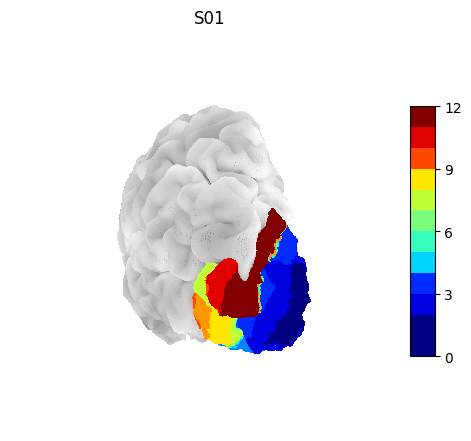

In [21]:
# surf_mesh = join(dir_work,'lh.inflated.surf.gii')
pial = join(dir_work,'lh.pial.surf.gii')
sulc = join(dir_work,'lh.sulc.shape.gii')

elev, azim = 0, 250
g = plotting.plot_surf_stat_map(
    surf_mesh=pial,
    stat_map=data,
    # threshold="90%",
    cmap=cm.jet.resampled(len(list_roi)+1), alpha=0.6, colorbar=True,
    bg_map=sulc,
    hemi='left', view=(elev, azim),
    darkness=None,
    title=subj,
)

In [22]:
# ## mris_convrt -c lh.benson14.varea.mgz lh.pial tmp.gii
# tmp = nb.load(join(dir_work,'lh.tmp.gii'))
# tmp

---

### Surface-to-Volume Transformationvolume

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:39<00:00,  8.31s/it]


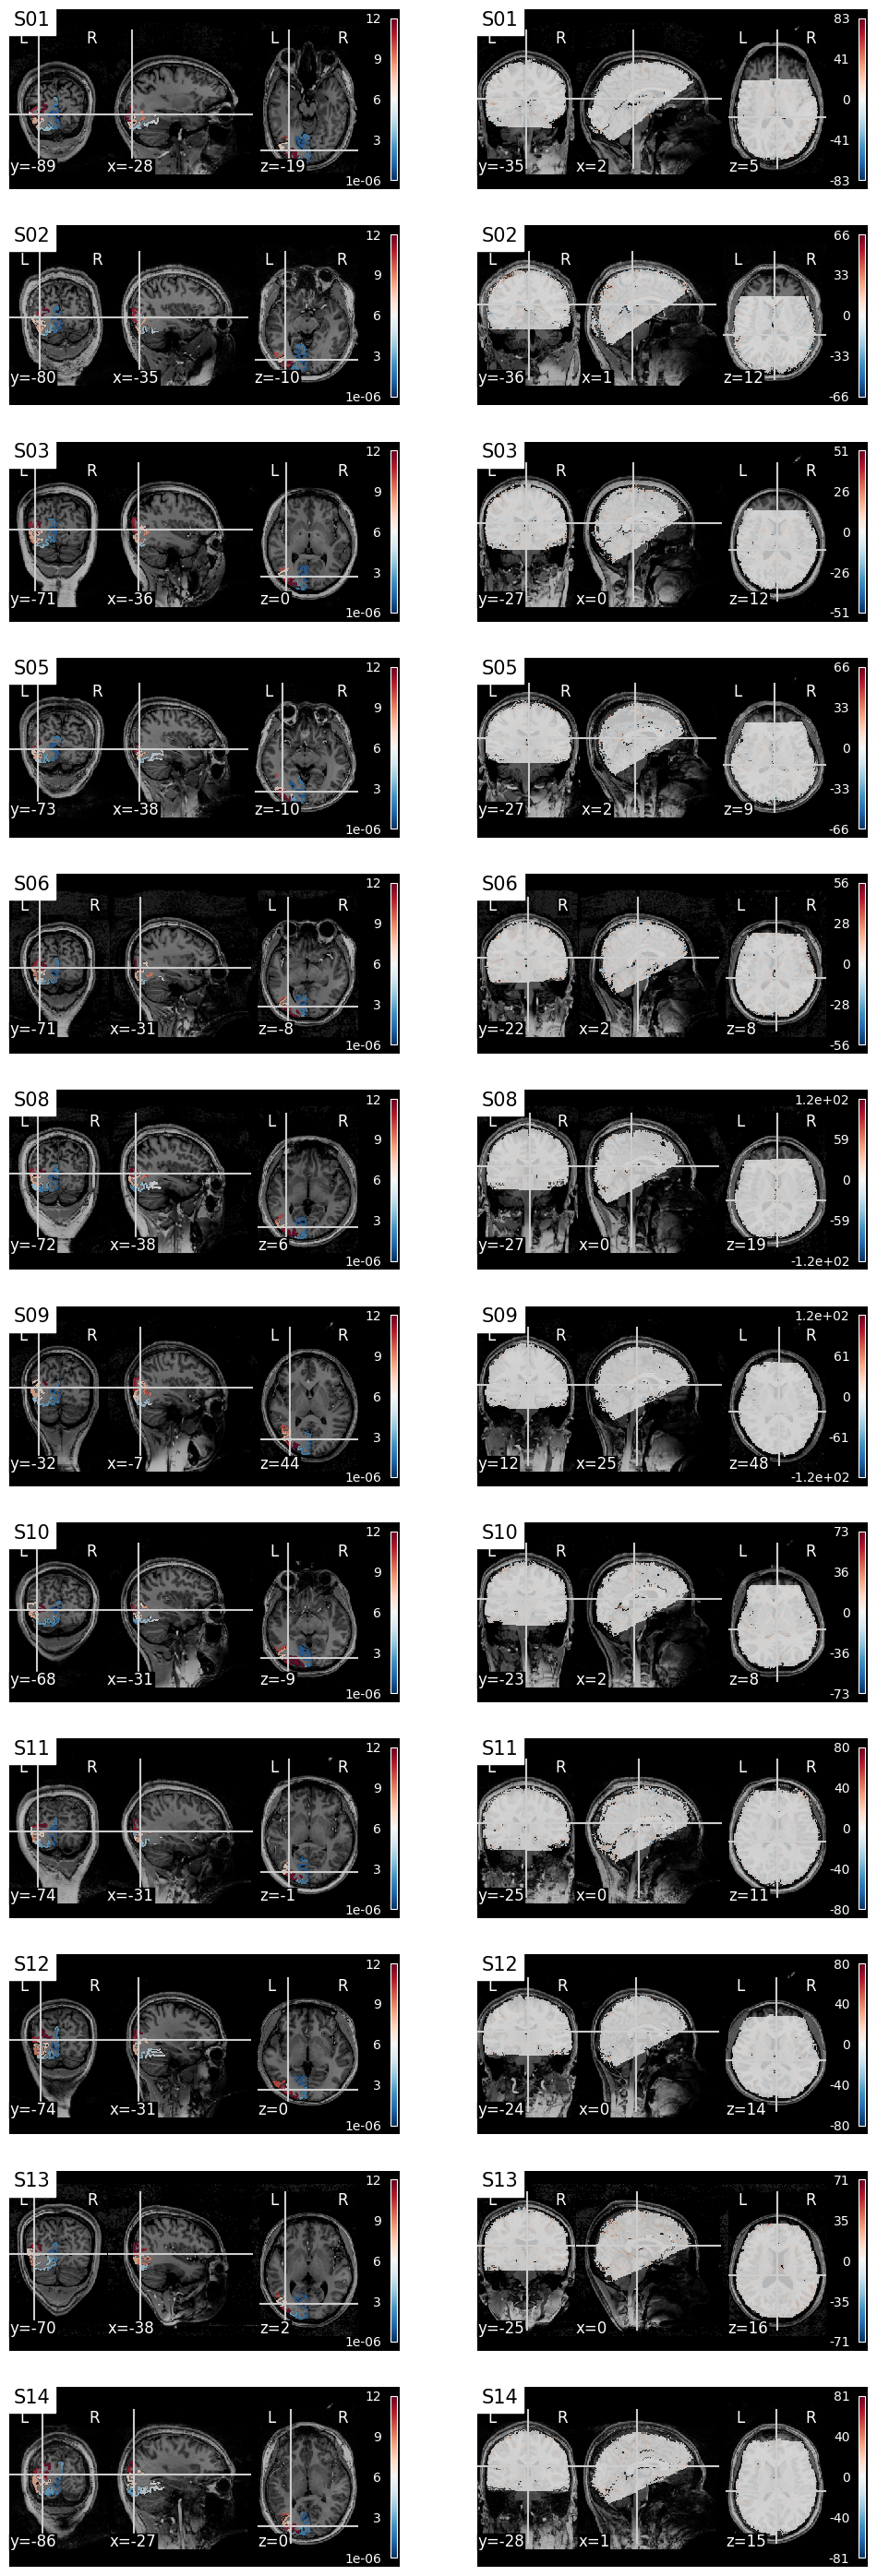

In [28]:
nrows = len(list_sn)
ncols = 2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,3*nrows))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Non-finite values detected. These values will be replaced with zeros.")
    for ii, sn in enumerate(tqdm(list_sn)):
        subj = 'S'+sn
        
        vol_orig = join(dir_fs,subj,'mri/orig.mgz')
        vol_varea = join(dir_fs,subj,'mri/lh.benson14_varea.vol.nii')
        # if not exists(vol_varea):
        #     command = 'mri_surf2vol --o %s/%s/mri/lh.benson14_varea.vol.nii --subject %s --so %s/%s/surf/lh.white %s/%s/surf/lh.benson14_varea.mgz'%(dir_fs,subj,subj,dir_fs,subj,dir_fs,subj)
        #     result = subprocess.run(command, shell=True, capture_output=True, text=True)
    
        # plotting.view_img(
        #     stat_map_img=vol_varea,
        #     bg_img=vol_orig
        # )
        plotting.plot_stat_map(
            stat_map_img=vol_varea,
            bg_img=vol_orig,
            transparency=0.75,
            resampling_interpolation='nearest',
            title=subj,
            axes=axs[ii,0]
        )
    
        vol_beta = join(dir_glm,subj,'beta_0001.nii')
    
        # plotting.view_img(
        #     stat_map_img=vol_beta,
        #     bg_img=vol_orig
        # )
        plotting.plot_stat_map(
            stat_map_img=vol_beta,
            bg_img=vol_orig,
            transparency=0.75,
            resampling_interpolation='nearest',
            title=subj,
            axes=axs[ii,1]
        )

---

### Extract beta values by ROI

In [33]:
dir_cache = '/Users//sungbeenpark/nilearn_cache'
makedirs(dir_cache, exist_ok=True)

In [56]:
masker = NiftiLabelsMasker(
    labels_img=vol_varea, labels=list_roi,
    verbose=0, memory=dir_cache
)

In [113]:
img = masker.labels_img_.get_fdata().astype(int)
for ii, roi in enumerate(list_roi):
    label = ii+1
    nvoxels = (img==label).sum()
    print(roi, nvoxels)

V1 1073
V2 1093
V3 755
hV4 401
VO1 389
VO2 218
LO1 269
LO2 214
TO1 235
TO2 156
V3b 231
V3a 687


In [57]:
betas = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Non-finite values detected. These values will be replaced with zeros.")
    for fname in tqdm(sorted(glob(join(dir_glm,subj,'beta_*.nii')))):
        beta = masker.fit_transform(fname)
        betas.append(beta)
betas = np.array(betas)
betas.shape

100%|███████████████████████████████████████████████████████████████████████| 544/544 [32:34<00:00,  3.59s/it]


---

In [54]:
reginfo = deal_spm.load_reginfo(subj=subj, dir_glm=dir_glm)
reginfo

,sn,run,name,ons
0,1,1,"(2,S)",6.03
1,1,1,"(4,S)",11.03
2,1,1,"(4,L)",16.03
3,1,1,"(2,L)",21.03
4,1,1,"(1,S)",26.03
...,...,...,...,...
539,1,8,"(3,S)",3215.03
540,1,8,"(3,L)",3220.03
541,1,8,"(2,S)",3225.03
542,1,8,"(2,L)",3230.03


In [86]:
line = {'subj':[],'cond':[]}
for ii, roi in enumerate(list_roi):
    line[roi] = []
    
for key in sorted(reginfo.name.unique()):
    idx = (reginfo.name == key).values
    line['subj'].append(subj)
    line['cond'].append(key)
    for ii, roi in enumerate(list_roi):
        line[roi].append(betas[idx].mean(axis=0)[ii])
        
df = pd.DataFrame(line)
df = pd.melt(
    df,
    id_vars=['subj','cond'],
    value_vars=list_roi,
    var_name='roi',
    value_name='beta'
)
df

,subj,cond,roi,beta
0,S01,"(1,L)",V1,0.378818
1,S01,"(1,S)",V1,0.584227
2,S01,"(2,L)",V1,0.375385
3,S01,"(2,S)",V1,0.476624
4,S01,"(3,L)",V1,0.204013
...,...,...,...,...
91,S01,"(2,S)",V3a,0.778053
92,S01,"(3,L)",V3a,0.043076
93,S01,"(3,S)",V3a,0.756916
94,S01,"(4,L)",V3a,-0.031120


<Axes: xlabel='roi', ylabel='beta'>

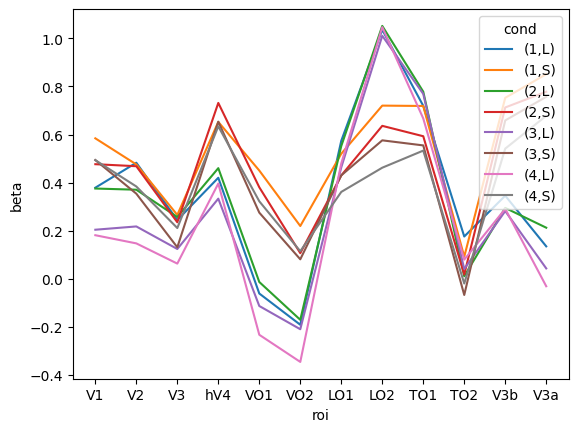

In [87]:
sns.lineplot(
    data=df,
    x='roi', y='beta', hue='cond'
)